In [381]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import uuid

In [400]:
class Bellman(object):
    
    def __init__(self, phi, C, T, r):
        
        self.s = 0    # current timestep
        self.c = 0    # spots occupied
        self.r = r    # parking rate
        self.C = C    # capacity 
        self.T = T    # total time steps before day starts
        self.z = None # reservation fee - to be determined by phi

        self.id = uuid.uuid1()
        self.msg = []
        self.n = np.zeros(T).astype(int)
        self.phi = phi
        self.log = pd.DataFrame(columns=['event','c','z','s','id'])
        
    def nu(self):
        s, T = self.s, self.T
        nu_val = np.zeros(T)
        nu_val[s:] = 1 / (1 + np.exp(self.z)) * (T - np.arange(T-s) + 1) / T
        nu_val[s] = 0.0 
        nu_val[self.n==1] = 0.0
        return nu_val 
    
    @staticmethod
    def alpha(s):
        return 0.15
    
    @staticmethod
    def beta(s,c):
        return 0.15 * c
    
    @staticmethod
    def mu(s):
        return 0.75
    
    def write_to_log(self, event):
        df = pd.DataFrame({'event': [event]
                           ,'c': [self.c]
                           ,'z': [self.z]
                           ,'s': [self.s]
                           ,'id': [self.id]
                          })
        self.log = self.log.append(df)
    
    def sample_event(self):
        
        # reservation arrival may occur
        if self.n[self.s] == 1: 
            if np.random.uniform() < mu(self.s):
                if self.c < self.C:
                    return ('RES_ARRIVAL', None)
                else:
                    raise Exception('Arrival of reservation, but no capacity available.')
            else:
                return ('RES_NO_SHOW', None)
            
        # no reservation, but spare capacity
        elif np.sum(self.n[self.s:]) + self.c < self.C: 
            nu_val = self.nu()
            alpha_val = self.alpha(self.s)
            beta_val = self.beta(self.s, self.c)
            probs = np.append(nu_val, [alpha_val, beta_val])

            if np.sum(probs) > 1.0:
                self.msg.append('np.sum(probs) > 1.0, rescale probabilities')
                probs /= np.sum(probs)
                probs = np.append(probs, 0.0)
            else:
                probs = np.append(probs, 1-np.sum(probs))
            
            events = ['RES_MADE'] * len(nu_val) + ['REG_ARRIVAL', 'DEPARTURE', 'NOTHING']
            i_event = np.random.choice(np.arange(len(events)), p=probs)
            event = events[i_event]
            
            return (event, i_event)
        
        # no reservation, no spare capacity
        else: 
            return ('GARAGE_FULL', None)
    
    def iterate(self, verbose):
        
        if self.s < self.T:
            self.z = self.phi(self.c, self.n)
            event, i_event = self.sample_event()
            self.msg.append('\ntime: {}, event: {}'.format(self.s, event))

            if event in ['REG_ARRIVAL', 'RES_ARRIVAL']:
                self.c += 1
            elif event == 'DEPARTURE':
                self.c -= 1
            elif event == 'RES_MADE':
                self.n[i_event] = 1
                self.msg.append('reservation is for time {}'.format(i_event))
            elif event not in ['NOTHING', 'GARAGE_FULL', 'RES_NO_SHOW']:
                raise Exception('Unknown event occured: {}'.format(event))
                
            self.msg.append('no of open res: {}'.format(np.sum(self.n[self.s+1:])))
            self.msg.append('no of occupied spots: {}'.format(self.c))
            
            if self.msg and verbose > 0:
                print('\nmsg:')
                for msg in self.msg:
                    print(msg)
                self.msg = []
                
            self.write_to_log(event)
            self.s += 1
        else: 
            raise Exception('Already at time T.')
            
    def run(self, verbose=0):
        for _ in range(T):
            self.iterate(verbose)
        
def phi(c,n):
    return 5.0

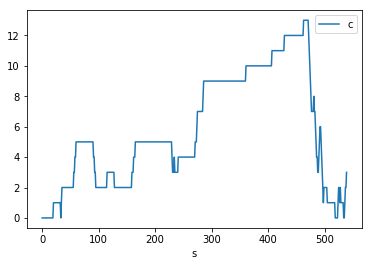

In [403]:
T = 540
C = 15
r = 2.00

# np.random.seed(1)
bellman = Bellman(phi,C,T,r)
bellman.run()

fig = bellman.log.plot(x='s',y='c')